<a href="https://colab.research.google.com/github/cemreefe/cmpe493-project/blob/main/word_embeddings_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install xmltodict

import os
import io   
import re
import json
import math
import pickle
import string
import tarfile
import xmltodict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_file(path):
  with open(path, 'r') as f:
    return f.read()

In [4]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493'):
  os.makedirs('drive/MyDrive/CMPE/CMPE493')

In [5]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'):
  !curl https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml --output drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt'):
  !curl https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt --output drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz'):
  !curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-07-16.tar.gz --output drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz

In [6]:
if not os.path.exists('2020-07-16'):
  tar = tarfile.open('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz', "r:gz")
  tar.extractall()
  tar.close()

In [7]:
df_metadata = pd.read_csv('2020-07-16/metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
del df_metadata['sha'], df_metadata['source_x'], df_metadata['doi'], df_metadata['pmcid'], df_metadata['pubmed_id'], df_metadata['license'], df_metadata['publish_time'], df_metadata['authors'], df_metadata['journal'], df_metadata['mag_id'], df_metadata['who_covidence_id'], df_metadata['arxiv_id'], df_metadata['pdf_json_files'], df_metadata['pmc_json_files'], df_metadata['url'], df_metadata['s2_id']

In [9]:
df_metadata.drop_duplicates(subset='cord_uid', keep='first', inplace=True)

In [10]:
df_metadata

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...
...,...,...,...
192504,z4ro6lmh,Rapid radiological improvement of COVID-19 pne...,NaN
192505,hi8k8wvb,SARS E protein in phospholipid bilayers: an an...,Abstract We report on an anomalous X-ray refle...
192506,ma3ndg41,Italian Society of Interventional Cardiology (...,COVID‐19 pandemic raised the issue to guarante...
192507,wh10285j,"Nimble, Together: A Training Program's Respons...",NaN


In [11]:
topic_relevances = 'topic iter document_id judgement\n' + read_file('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt')

df_relevances = pd.read_csv(  io.StringIO(topic_relevances)  , sep=" ")
del df_relevances['iter']

df_relevances

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [12]:
topics_obj = xmltodict.parse(read_file('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'))
topics     = json.loads(json.dumps(topics_obj))

topics_dict = {}
for topic in topics['topics']['topic']:
  # a topic has the following fields:
  #  * @number
  #  * narrative
  #  * query
  #  * question
  topics_dict[topic['@number']] = topic['query'] + ' ' + topic['question'] + ' ' + topic['narrative']

# Data so far

* `topics_dict` 
      has `topic-id` for keys, and topic description for values
* `df_relevances` 
      has the following three columns:
      topic	document-id	judgement
* `df_metadata`
      holds information about the documents
      has the following three columns (others are deleted):
      cord_uid	title	abstract


In [139]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
docs = np.array(df_metadata)
contents = {}

# create a contents dictionary with all contents of a document
for doc in docs:
  contents[doc[0]] = f'{doc[1]} {doc[2]}'

In [16]:
porter_stemmer = PorterStemmer()
sw = stopwords.words('english')

# preprocessing
# case folding
# punctuation removal
# number deletion
# stemming & stopword removal
def preprocess(s):
  s = s.casefold()
  s = s.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
  #s = re.sub("\d+", "", s) #Delete numbers
  s = ' '.join([porter_stemmer.stem(word) for word in s.split() if word not in sw and word != 'nan'])
  return s

### `contents` is a dictionary with document id keys and f'{document title} {document content}' values.
```
document_id: f'{document_title} {document_content}'
```

In [17]:
################################################## WORD EMBEDDINGS ##########################################################

In [18]:
# download spacy model
!python3 -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [19]:
import spacy

In [20]:
# load the spacy English model
# disable unused parts of the spacy pipeline (to speed up the process)
nlp_stripped = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner', 'entity_linker', 'entity_ruler', 'textcat', 'lemmatizer', 'morphologizer', 'attribute_ruler', 'senter', 'sentencizer', 'tok2vec', 'transformer'])

In [25]:
# DISCLAIMER: our numerous trials have shown that preprocessing, 
# although costly, often results in a decrease in performance

# whether or not to use preprocessing
preprocessing = False

In [26]:
%%time

# takes around 3mins with preprocessing
if preprocessing:
  preprocessed_contents = list(map(preprocess, contents.values()))
  preprocessed_topic_contents = list(map(preprocess, topics_dict.values()))
else:
  preprocessed_contents = list(contents.values())
  preprocessed_topic_contents = list(topics_dict.values())

CPU times: user 8.09 ms, sys: 911 µs, total: 9 ms
Wall time: 9.52 ms


In [28]:
%%time

# ~100 sec operation
doc_content_list = []
doc_content_list = list(nlp_stripped.pipe(preprocessed_contents))

topic_content_list = []
topic_content_list = list(nlp.pipe(preprocessed_topic_contents))

CPU times: user 1min 38s, sys: 7.26 s, total: 1min 45s
Wall time: 1min 45s


In [30]:
%%time

# ~320 sec operation
doc_vector_list   = list(map(lambda x: x.vector, doc_content_list))
topic_vector_list = list(map(lambda x: x.vector, topic_content_list))

CPU times: user 5min 14s, sys: 1.88 s, total: 5min 16s
Wall time: 5min 15s


In [34]:
del doc_content_list, topic_content_list, preprocessed_contents, preprocessed_topic_contents, df_metadata

In [38]:
cos_sims = cosine_similarity(doc_vector_list, topic_vector_list)
man_dist = manhattan_distances(doc_vector_list, topic_vector_list)
euc_dist = euclidean_distances(doc_vector_list, topic_vector_list)

CPU times: user 4.06 s, sys: 1.76 s, total: 5.82 s
Wall time: 4.67 s


In [142]:
%%time

# index lookup dictionary for document ids
lookup_ck = {
    key: i
    for i, key in enumerate(contents.keys())
}

# index lookup dictionary for topic ids
lookup_tk = {
    int(key): i
    for i, key in enumerate(topics_dict.keys())
}

# dataset
X_all, y_all     = [], []
X_train, y_train = [], []
X_test, y_test   = [], []


for row in np.array(df_relevances):
  
  ck_index = lookup_ck[row[1]]
  tk_index = lookup_tk[row[0]]
  
  # a datapoint x in the dataset is an array of length 311:
  x = np.hstack([
    # the first 300 elements:
    # the elementwise difference between the document and topic vectors
    doc_vector_list[ck_index] - topic_vector_list[tk_index],
    # the other 11 elements are certain statistics about these vectors
    [
      # cosine similarity between the two vectors
      cos_sims[ck_index, tk_index],
      # manhattan distance between the two vectors
      man_dist[ck_index, tk_index],
      # euclidean distance between the two vectors
      euc_dist[ck_index, tk_index],
      # mean of the document vector
      np.mean(doc_vector_list[ck_index]),
      # mean of the topic vector
      np.mean(topic_vector_list[tk_index]),
      # mean of the absolute values of the document vector
      np.mean(abs(doc_vector_list[ck_index])),
      # mean of the absolute values of the topic vector
      np.mean(abs(topic_vector_list[tk_index])),
      # standard deviation of the document vector
      np.std(doc_vector_list[ck_index]),
      # standard deviation of the topic vector
      np.std(topic_vector_list[tk_index]),
      # standard deviation of the absolute valued document vector
      np.std(abs(doc_vector_list[ck_index])),
      # standard deviation of the absolute valued topic vector
      np.std(abs(topic_vector_list[tk_index])),
    ],
  ])
  
  if row[0] % 2:
    X_train.append(x)
    y_train.append(np.array([row[2]/2]))
  else:
    X_test.append(x)
    y_test.append(np.array([row[2]/2]))
  
  X_all.append(x)
  y_all.append(np.array([row[2]/2]))

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_all = np.array(X_all)
y_all = np.array(y_all)

CPU times: user 13.7 s, sys: 289 ms, total: 14 s
Wall time: 13.6 s


In [143]:
print('train set X:', X_train.shape, 'y:', y_train.shape)
print('test set  X:', X_test.shape, 'y:', y_test.shape)

train set X: (35894, 311) y: (35894, 1)
test set  X: (33424, 311) y: (33424, 1)


In [144]:
%%time 

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# we will use a very small neural network because the data is easily overfitted
# we will also make use of batch normalization and dropout (0.5)
# Our data has 311 features, so the model will be:
# 311 -> 4 -> 8 -> 1 (all dense layers)

# define a sequential keras model
model = Sequential()

# layer 1
model.add(Dense(4, input_dim=311, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# layer 2
model.add(Dense(8, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# layer 3
model.add(Dense(1, activation='sigmoid'))

# define early stopping to avoid unnecessary training and overfitting
# return to best weights after stop
# REF: https://stackoverflow.com/questions/48285129/saving-best-model-in-keras/48286003
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# compile the keras model with mean square error loss
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# fit the keras model on the dataset
history = model.fit(
    X_train[:], 
    y_train[:], 
    epochs=200, 
    batch_size=1000, 
    verbose=1, 
    validation_data=(X_test, y_test),
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/200
36/36 [==============================] - 1s 15ms/step - loss: 0.2343 - mse: 0.2343 - val_loss: 0.2568 - val_mse: 0.2568
Epoch 2/200
36/36 [==============================] - 0s 8ms/step - loss: 0.2151 - mse: 0.2151 - val_loss: 0.2252 - val_mse: 0.2252
Epoch 3/200
36/36 [==============================] - 0s 9ms/step - loss: 0.1999 - mse: 0.1999 - val_loss: 0.2065 - val_mse: 0.2065
Epoch 4/200
36/36 [==============================] - 0s 8ms/step - loss: 0.1871 - mse: 0.1871 - val_loss: 0.1940 - val_mse: 0.1940
Epoch 5/200
36/36 [==============================] - 0s 8ms/step - loss: 0.1773 - mse: 0.1773 - val_loss: 0.1845 - val_mse: 0.1845
Epoch 6/200
36/36 [==============================] - 0s 9ms/step - loss: 0.1691 - mse: 0.1691 - val_loss: 0.1796 - val_mse: 0.1796
Epoch 7/200
36/36 [==============================] - 0s 8ms/step - loss: 0.1634 - mse: 0.1634 - val_loss: 0.1774 - val_mse: 0.1774
Epoch 8/200
36/36 [==============================] - 0s 8ms/step - loss: 0.1605 - 

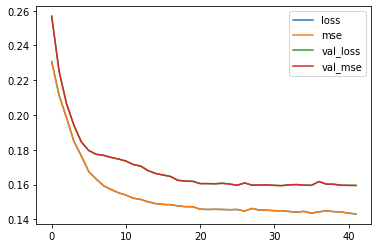

In [145]:
# plot loss history
for key, hist in history.history.items():
  if key == 'lr':
    continue
  plt.plot(hist, label=key)
plt.legend()

In [146]:
pred_all = model.predict(X_all)

rel_nn = np.array(rel)
for i in range(len(rel_nn)):
  rel_nn[i][-1] = pred_all[i][0]

rel_nn

array([[1, '005b2j4b', 0.3877328],
       [1, '00fmeepz', 0.323334],
       [1, '010vptx3', 0.33921647],
       ...,
       [50, 'zwsvlnwe', 0.5133299],
       [50, 'zxr01yln', 0.28957987],
       [50, 'zz8wvos9', 0.5292808]], dtype=object)

In [147]:
results = []
for i, row in enumerate(rel_nn):
  if not row[0] % 2:
    results.append(f'{row[0]} 0 {row[1]} 0 {row[2]} 0')

In [148]:
results[:10]

['2 0 01goni72 0 0.3947508931159973 0',
 '2 0 01yc7lzk 0 0.30791807174682617 0',
 '2 0 02cy1s8x 0 0.16445490717887878 0',
 '2 0 02f0opkr 0 0.28832077980041504 0',
 '2 0 03h85lvy 0 0.3423709273338318 0',
 '2 0 03id5o2g 0 0.1404300332069397 0',
 '2 0 03s9spbi 0 0.33893638849258423 0',
 '2 0 04awj06g 0 0.24142131209373474 0',
 '2 0 04rbtmmi 0 0.31168097257614136 0',
 '2 0 084o1dmp 0 0.1675756573677063 0']

In [149]:
# Write results to file
with open('results_we_nn_69_nprep_early_stopping_bf.txt', 'w') as f:
    f.write('\n'.join(results))